# USGS Gages Calibration

**Written by**: Colin Richardson  
**Last updated**: 9.12.23  
**Python version**: 3.9.16


**Input files**: 
1) wake gage list.csv
2) wake_catchmask.shp
3) wake_flows.shp
4) nc_src.csv

# Import necessary libraries

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import geopandas as gpd
import os
import time
import glob
from urllib.request import urlretrieve
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Download USGS field measurement data

I determined the sites to download data for using the USGS site service (https://waterservices.usgs.gov/rest/Site-Test-Tool.html). I initially got a list of all active sites within Wake County that have field measurements of stage and discharge using this url (https://waterservices.usgs.gov/nwis/site/?format=rdb&countyCd=37183&siteStatus=active&hasDataTypeCd=sv). This returned a list with 19 sites, but when I inspected the period of record for field measurements at each site I discovered only 15 of the 19 had up to date field measurements available. These are the sites included in the file "wake gage list.csv"

The loop I used is commented out since I already downloaded the files, but this is how I automated the download originally. You may need to change the file paths to work on your system if you want to recreate this workflow.

In [16]:
sites = pd.read_csv('field measurements/wake gage list.csv', dtype= {'site_no':'object'})

# cwd = os.getcwd()
# for site in sites['site_no']:
#     url = 'https://waterdata.usgs.gov/nwis/measurements?site_no=' + site + '&agency_cd=USGS&format=rdb'
#     path = cwd + '\\field measurements\\' + site + '.txt'
#     urlretrieve(url, path)
#     print('finished downloading for', site)
#     time.sleep(1)

# Determine which catchment each gage falls within

I also check that the drainage area associated with the stream gage and the drainage area associated with the catchments line up. This ensures that the USGS and synthetic rating curves are actually referring to the same basins

In [18]:
# convert .csv input into a geodataframe using the lat-long points as the geometry
gagesgdf = gpd.GeoDataFrame(sites, geometry=gpd.points_from_xy(sites.dec_long_va, sites.dec_lat_va), crs="EPSG:4269")

# read in the catchment shapefile for Wake County 
catch = gpd.read_file('wake_catchmask.shp')

# read in the flowline shapefile for Wake County
wakeflow = gpd.read_file('wake_flows.shp')

# join to the catchments and flow lines to get the total drainage area for each catchment
wakecatch = catch.merge(wakeflow[['COMID','TotDASqKM','SLOPE']], left_on = 'catchmask', right_on = 'COMID', validate = '1:1')

# read in the SRC table for all of NC
ncsrc = pd.read_csv('nc_src.csv')

Here I spatially join the catchments shapefile to the USGS gage point locations to see which COMID corresponds to which USGS gage. I then print a table showing the USGS sites, COMIDs, and the drainage area values from USGS and the catchments to confirm they generally line up

In [19]:
gagecatch = wakecatch.sjoin(gagesgdf, how = 'right')
gagecatch['TotDASqMi'] = gagecatch['TotDASqKM'] * 0.386102
gagecatch[['site_no','station_nm','TotDASqMi','drain_area_va','TotDASqKM','COMID']]

,site_no,station_nm,TotDASqMi,drain_area_va,TotDASqKM,COMID
0,02087183,"NEUSE RIVER NEAR FALLS, NC",771.770253,771.00,1998.8766,8782659
1,0208726005,"CRABTREE CR AT EBENEZER CHURCH RD NR RALEIGH, NC",76.813410,76.00,198.9459,8783277
2,02087275,"CRABTREE CREEK AT HWY 70 AT RALEIGH, NC",98.653964,97.60,255.5127,8783339
3,02087324,"CRABTREE CREEK AT US 1 AT RALEIGH, NC",121.881011,121.00,315.6705,8783667
4,0208732885,"MARSH CREEK NEAR NEW HOPE, NC",7.676789,6.84,19.8828,8783643
5,02087337,"WALNUT CREEK AT BUCK JONES ROAD AT RALEIGH, NC",3.891561,3.36,10.0791,8783945
6,0208734210,"WALNUT CREEK AT TRAILWOOD DRIVE AT RALEIGH, NC",9.092470,9.32,23.5494,8783959
7,0208734795,WALNUT CREEK AT SOUTH WILMINGTON ST AT RALEIGH...,17.247061,17.20,44.6697,8784035
8,02087359,"WALNUT CREEK AT SUNNYBROOK DRIVE NR RALEIGH, NC",29.841553,29.80,77.2893,8784005
9,02087580,"SWIFT CREEK NEAR APEX, NC",21.524685,21.00,55.7487,8785997


Here I am subsetting the src table to only include the gages included in gagecatch

In [20]:
src = ncsrc[ncsrc.CatchId.isin(gagecatch.COMID)]

# Adjust USGS field measurements to match SRC zero stage value
Because the SRCs are referenced to the zero stage value for each reach, we need to adjust the USGS field measurement data to match this definition of "zero stage". Right now, the USGS data is referenced to the gage datum at some NAVD88 elevation, so we need to find the DEM elevation nearby each of the gage points, and then subtract this value from each water surface elevation field measurement so the USGS stage and SRC stage values are lined up properly.

In the output of the cell below, you can see that one of the sites had 5 points discarded because they fell below the DEM elevation

In [21]:
for i in range(len(gagecatch)):
    demelev = gagecatch['dem_elev_m'][i]
    usgspath = 'field measurements/' + gagecatch['site_no'][i] + '.txt'

    ## old line taking 50 most recent values
    usgsdf = pd.read_csv(usgspath, sep= '\t', skiprows=14).drop(0).astype({'gage_height_va':'float64', 'discharge_va':'float64'}).dropna(subset = ['discharge_va', 'gage_height_va'])[-50:].sort_values(by = 'discharge_va')
    usgsdf = usgsdf[usgsdf['measured_rating_diff'] != 'Poor']
    
    ## new lines taking 20 highest values with measurement ratings not equal to poor
    # usgsdf = pd.read_csv(usgspath, sep= '\t', skiprows=14).drop(0).astype({'gage_height_va':'float64', 'discharge_va':'float64'}).dropna(subset = ['discharge_va', 'gage_height_va'])
    # usgsdf = usgsdf[usgsdf['measured_rating_diff'] != 'Poor'].sort_values(by = 'discharge_va').reset_index(drop = True)[-20:]
    usgsdf['gage_height_va_m'] = usgsdf['gage_height_va'] * 0.3048
    usgsdf['gage_elev_va_m'] = usgsdf['gage_height_va_m'] + (gagecatch['alt_va'][i] * 0.3048) 
    usgsdf['discharge_va_m3s'] = usgsdf['discharge_va'] * 0.028316847
    if sum(usgsdf['gage_elev_va_m'] < demelev) > 0:
        usgsdf = usgsdf[usgsdf['gage_elev_va_m'] > demelev]
    usgsdf['gage_height_va_m_adj'] = usgsdf['gage_elev_va_m'] - demelev
    
    print('USGS gage', gagecatch['site_no'][i], '# of points =', len(usgsdf))
    # print('USGS gage', gagecatch['site_no'][i],"% points below DEM =", sum((usgsdf['gage_elev_va_m'] - demelev) < 0)/len(usgsdf)*100)

USGS gage 02087183 # of points = 49
USGS gage 0208726005 # of points = 48
USGS gage 02087275 # of points = 47
USGS gage 02087324 # of points = 42
USGS gage 0208732885 # of points = 42
USGS gage 02087337 # of points = 33
USGS gage 0208734210 # of points = 44
USGS gage 0208734795 # of points = 38
USGS gage 02087359 # of points = 48
USGS gage 02087580 # of points = 32
USGS gage 0208758850 # of points = 37
USGS gage 02088383 # of points = 38
USGS gage 0209782609 # of points = 24


This plot gives a sense of how the points are adjusted to better match the SRC definition of stage

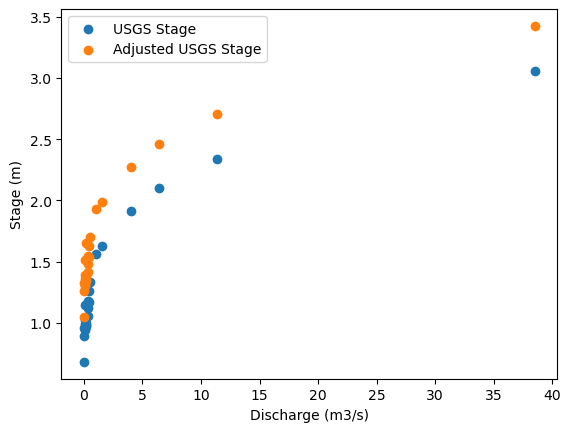

In [22]:
test = usgsdf
plt.scatter(test['discharge_va_m3s'], test['gage_height_va_m'], label = 'USGS Stage')
plt.scatter(test['discharge_va_m3s'], test['gage_height_va_m_adj'], label = 'Adjusted USGS Stage')
plt.xlabel('Discharge (m3/s)')
plt.ylabel('Stage (m)')
plt.legend()

# Calibrate the Manning's n value for each catchment to match the USGS rating curve

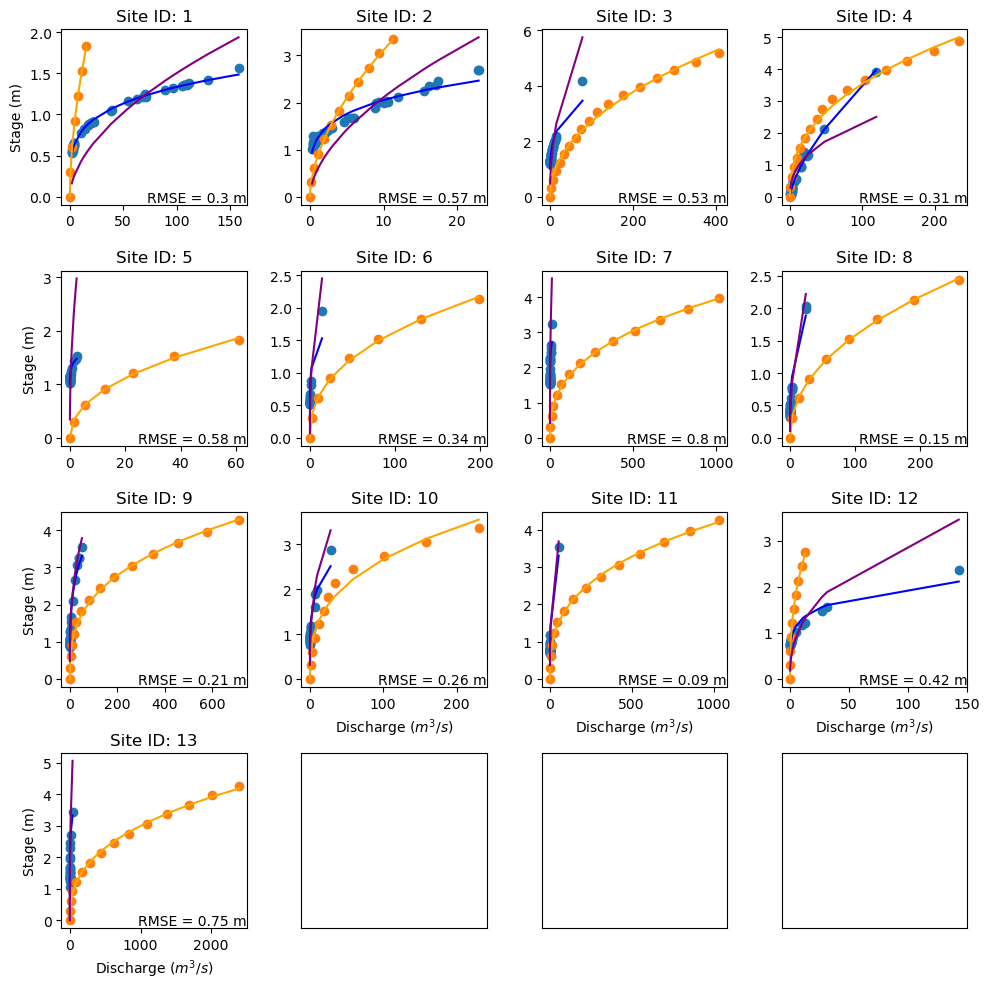

In [29]:
# This is the form of the rating curve (RC) function used for all the USGS and SRC data
def f(x,a,b): 
    return a*x**b

# Make the final 4x4 plot object
fig, ax = plt.subplots(4,4, figsize = (10,10))

# Initialize some columns in the output dataframe
gagecatch['USGS_a'] = 0
gagecatch['USGS_b'] = 0
gagecatch['USGS_R2'] = 0
gagecatch['USGS_n_points'] = 0
gagecatch['src_a'] = 0
gagecatch['src_b'] = 0
gagecatch['src_R2'] = 0
gagecatch['src_a_opt'] = 0
gagecatch['scale_factor'] = 0
gagecatch['mannings_n_opt'] = 0
gagecatch['rmse'] = 0
gagecatch['src_cal_R2'] = 0

# loop through each gage location in gagecatch
for i in range(len(gagecatch)):
    
    # find the dem elevation for that gage
    demelev = gagecatch['dem_elev_m'][i]

    # read the USGS file for each gage, convert gage_height_va and discharge_va to floats, drop any columns with NA gage height or discharge, 
    # take a subset of the most recent 50 values, and sort those values by discharge. Discard any measurements with "Poor" rating from USGS
    usgspath = 'field measurements/' + gagecatch['site_no'][i] + '.txt'
    usgsdf = pd.read_csv(usgspath, sep= '\t', skiprows=14).drop(0).astype({'gage_height_va':'float64', 'discharge_va':'float64'}).dropna(subset = ['discharge_va', 'gage_height_va'])[-50:].reset_index().sort_values(by = 'discharge_va')
    usgsdf = usgsdf[usgsdf['measured_rating_diff'] != 'Poor']
    maxdisch = usgsdf['discharge_va'].max()
    # print("site ID:", i+1, 'max discharge =', maxdisch, 'cfs')
    gagecatch.loc[i,'USGS_n_points'] = len(usgsdf)
    
    
    # convert gage height from ft to meters
    usgsdf['gage_height_va_m'] = usgsdf['gage_height_va'] * 0.3048

    # convert gage heights to elevation using the gage datum
    usgsdf['gage_elev_va_m'] = usgsdf['gage_height_va_m'] + (gagecatch['alt_va'][i] * 0.3048) 

    # discard any measurements with elevations below the dem elevation
    if sum(usgsdf['gage_elev_va_m'] < demelev) > 0:
        usgsdf = usgsdf[usgsdf['gage_elev_va_m'] > demelev]

    # adjust the gage heights to match the SRC stage definition
    usgsdf['gage_height_va_m_adj'] = usgsdf['gage_elev_va_m'] - demelev

    # convert discharge from ft3/s to m3/s
    usgsdf['discharge_va_m3s'] = usgsdf['discharge_va'] * 0.028316847

    # find the SRC rows corresponding to the catchment where the USGS gage falls
    gagesrc = src[src['CatchId'] == gagecatch['COMID'][i]]

    # subset the SRC to only include rows with stages close to or below the max stage in the usgsdf
    gagesrc = gagesrc[gagesrc['Stage'] < np.max(usgsdf['gage_height_va_m_adj'])*1.25] 

    # fit the RC function to the USGS measurements and save the a, b, and R2 values for the fit
    popt1, pcov1 = curve_fit(f, usgsdf['discharge_va_m3s'], usgsdf['gage_height_va_m_adj'])
    gagecatch.loc[i,'USGS_a'] = popt1[0]
    gagecatch.loc[i,'USGS_b'] = popt1[1]
    gagecatch.loc[i,'USGS_R2'] = r2_score(usgsdf['gage_height_va_m_adj'], f(usgsdf['discharge_va_m3s'], *popt1))

    # fit the RC function to the SRC points based off the blanket roughness value of 0.05
    # also save the a, b, and R2 values for the fit
    popt2, pcov2 = curve_fit(f, gagesrc['Discharge (m3s-1)'], gagesrc['Stage'])
    gagecatch.loc[i,'src_R2'] = r2_score(gagesrc['Stage'], f(gagesrc['Discharge (m3s-1)'], *popt2))

    # define a new RC function, where I can hold the b coefficient constant for each SRC RC
    def f2(x,a):
        return a*x**popt2[1]

    # refit the SRC RC to the USGS RC values holding the b coefficient constant to create the calibrated SRC RC
    popt3, pcov3 = curve_fit(f2, usgsdf['discharge_va_m3s'], f(usgsdf['discharge_va_m3s'], *popt1))

    # save coefficient values to the output dataframe
    gagecatch.loc[i,'src_a'] = popt2[0]
    gagecatch.loc[i,'src_b'] = popt2[1]
    gagecatch.loc[i,'src_a_opt'] = popt3[0]
    gagecatch.loc[i,'src_cal_R2'] = r2_score(f(usgsdf['discharge_va_m3s'], *popt1), f(usgsdf['discharge_va_m3s'], popt3[0], popt2[1]))

    # calculate the RC scale factor as the ratio of the calibrated and the uncalibrated SRC RC a coefficient values
    scalefac = popt3[0]/popt2[0]
    gagecatch.loc[i,'scale_factor'] = scalefac

    # calculate the Manning's roughness value associated with the scale factor
    mannings = (scalefac**(1/popt2[1])) * 0.05
    gagecatch.loc[i,'mannings_n_opt'] = mannings

    # calculate the RMSE between the USGS RC and calibrated SRC RC
    mse = mean_squared_error(f(usgsdf['discharge_va_m3s'], *popt1), f(usgsdf['discharge_va_m3s'], popt3[0], popt2[1]))
    rmse = np.sqrt(mse)
    gagecatch.loc[i,'rmse'] = rmse

    # set up some plotting indexes
    if i <= 3:
        j = i
        k = 0
    if i >= 4 and i <= 7:
        j = i-4
        k = 1
    if i >= 8 and i <= 11:
        j = i-8
        k = 2
    if i >= 12:
        j = i-12
        k = 3

    # plot the usgs points
    ax[k,j].scatter(usgsdf['discharge_va_m3s'], usgsdf['gage_height_va_m_adj'], label = 'USGS field measurements')

    # plot the USGS RC
    ax[k,j].plot(usgsdf['discharge_va_m3s'], f(usgsdf['discharge_va_m3s'], *popt1), color = 'blue', label = 'USGS RC')

    # plot the SRC points
    ax[k,j].scatter(gagesrc['Discharge (m3s-1)'], gagesrc['Stage'], label = 'SRC points')

    # plot the uncalibrated SRC RC
    ax[k,j].plot(gagesrc['Discharge (m3s-1)'], f(gagesrc['Discharge (m3s-1)'], *popt2), color = 'orange', label = 'Uncalibrated SRC RC')

    # plot the calibrated SRC RC
    ax[k,j].plot(usgsdf['discharge_va_m3s'], f(usgsdf['discharge_va_m3s'], popt3[0], popt2[1]), color = 'purple', label = 'Calibrated SRC RC')

    # title each plot according to Site ID in Table 1 & Table 2
    ax[k,j].set_title(f'Site ID: {i+1}')

    # # add the RMSE label to each plot
    # ax[k,j].annotate(f'RMSE = {np.round(rmse,2)} m', xy=(1, 0), xycoords='axes fraction', fontsize=10,
    #             horizontalalignment='right', verticalalignment='bottom')

    ax[k,j].annotate(f'RMSE = {np.round(rmse,2)} m', xy=(1, 0), xycoords='axes fraction', fontsize=10,
                horizontalalignment='right', verticalalignment='bottom')

    # add the labels to the axes
    ax[3,3].xaxis.set_major_locator(ticker.NullLocator())
    ax[3,3].yaxis.set_major_locator(ticker.NullLocator())
    ax[3,2].xaxis.set_major_locator(ticker.NullLocator())
    ax[3,2].yaxis.set_major_locator(ticker.NullLocator())
    ax[3,1].xaxis.set_major_locator(ticker.NullLocator())
    ax[3,1].yaxis.set_major_locator(ticker.NullLocator())
    ax[0,0].set_ylabel('Stage (m)')
    ax[1,0].set_ylabel('Stage (m)')
    ax[2,0].set_ylabel('Stage (m)')
    ax[3,0].set_ylabel('Stage (m)')
    ax[3,0].set_xlabel('Discharge ($m^3/s$)')
    ax[2,1].set_xlabel('Discharge ($m^3/s$)')
    ax[2,2].set_xlabel('Discharge ($m^3/s$)')
    ax[2,3].set_xlabel('Discharge ($m^3/s$)')

# make the figure layout tight
fig.tight_layout()

## save the figure at high dpi
# plt.rcParams['savefig.dpi']=450
# plt.savefig('USGS_adjusted_stage_gage_results.tif')

## save the output to csv. I drop geometry as it can interfere with the csv export
# gagecatch = gagecatch.rename(columns={"scale_factor": "scale_factor_gage", "mannings_n_opt": "mannings_n_opt_gage"})
# gagecatch.drop('geometry', axis = 1).to_csv('gage_adjusted_stage_output_final.csv')

This is just one of the plots from above shown larger. I used this figure for Site ID: 1 as figure 3

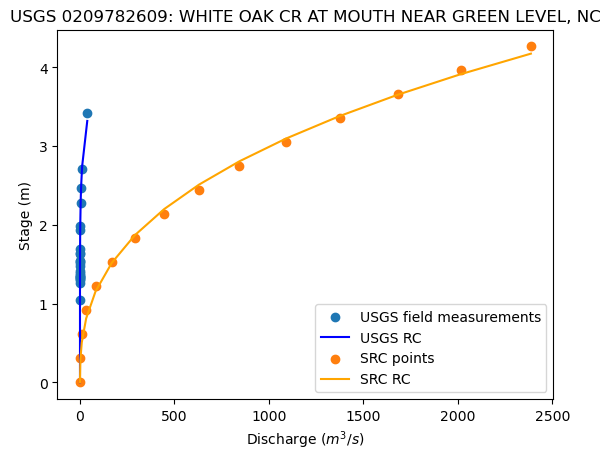

In [25]:
fig, ax= plt.subplots()
ax.scatter(usgsdf['discharge_va_m3s'], usgsdf['gage_height_va_m_adj'], label = 'USGS field measurements')
ax.plot(usgsdf['discharge_va_m3s'], f(usgsdf['discharge_va_m3s'], *popt1), color = 'blue', label = 'USGS RC')
ax.scatter(gagesrc['Discharge (m3s-1)'], gagesrc['Stage'], label = 'SRC points')
ax.plot(gagesrc['Discharge (m3s-1)'], f(gagesrc['Discharge (m3s-1)'], *popt2), color = 'orange', label = 'SRC RC')
# ax.plot(usgsdf['discharge_va_m3s'], f(usgsdf['discharge_va_m3s'], popt3[0], popt2[1]), color = 'purple', label = 'Calibrated SRC RC')
ax.set_xlabel('Discharge ($m^3/s$)')
ax.set_ylabel('Stage (m)')
site_na = gagecatch['station_nm'][i]
site_no = gagecatch['site_no'][i]
ax.set_title(f'USGS {site_no}: {site_na}')
ax.legend()
# plt.rcParams['savefig.dpi']=450
# plt.savefig('usgs_gage_calibration.tif')